# Time Series Analysis 

After doing the time series exercise in this chapter, I realized the knowledge gaps I have with time series, so here is another tutorial I worked on: [medium blog post](https://medium.com/open-machine-learning-course/open-machine-learning-course-topic-9-time-series-analysis-in-python-a270cb05e0b3)

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from dateutil.relativedelta import relativedelta
from scipy.optimize import minimize

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product
from tqdm import tqdm_notebook

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
ads = pd.read_csv('/home/mathlizard/Downloads/ads.csv', index_col=['Time'], parse_dates=['Time'])

In [3]:
currency = pd.read_csv('/home/mathlizard/Downloads/currency.csv', index_col=['Time'], parse_dates=['Time'])

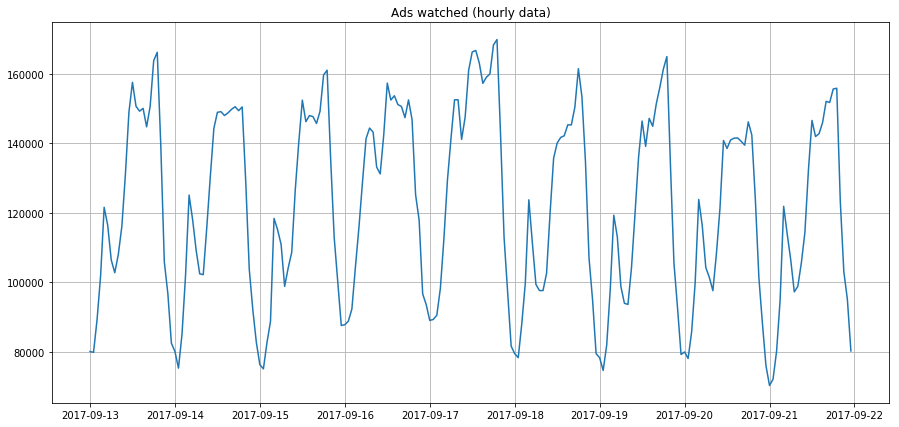

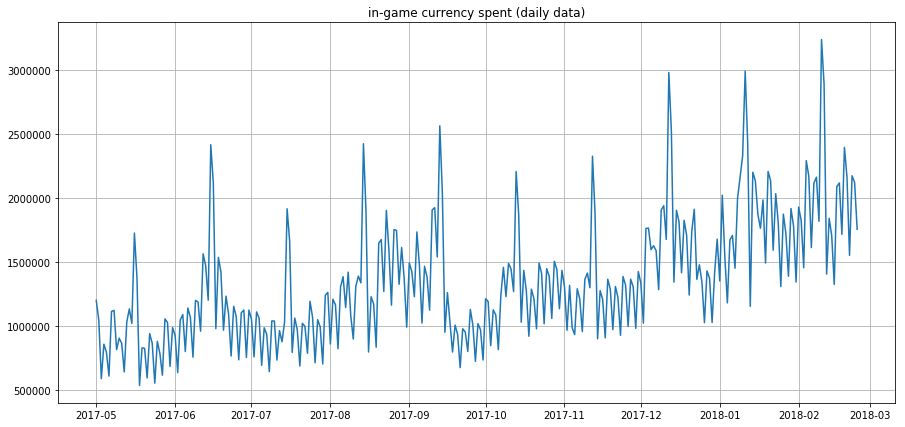

In [4]:
plt.figure(figsize=(15,7))
plt.plot(ads.Ads)
plt.title('Ads watched (hourly data)')
plt.grid(True)
plt.show()

plt.figure(figsize=(15,7))
plt.plot(currency.GEMS_GEMS_SPENT)
plt.title('in-game currency spent (daily data)')
plt.grid(True)
plt.show()

In [5]:
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true-y_pred)/y_true))*100

# Move, Smooth, Evaluate
Start with a baseline:  "tomorrow will be the same as the average of the past k days"

In [6]:
def moving_average(series, n):
    return np.average(series[-n:])

moving_average(ads, 24) #average of the last 24 hours 

116805.0

The moving average smoothes the original time series, and this can be useful when finding trends. 

In [9]:
def plotMovingAverage(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False):
    """
    series - dataframe with time series
    window - rolling window size
    plot_intervals - show confidence intervals
    plot_anomalies - show anomalies
    """
    rolling_mean = series.rolling(window=window).mean()
    
    plt.figure(figsize=(15,5))
    plt.title(f"Moving average\n window size = {window}")
    plt.plot(rolling_mean, 'g', label="Rolling mean trend")
    
    # plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bound = rolling_mean - (mae + scale*deviation)
        upper_bound = rolling_mean + (mae+scale*deviation)
        plt.plot(upper_bound, "r--", label = "Upper Bound / Lower Bound")
        plt.plot(lower_bound, "r--")
        
        #having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index = series.index, columns = series.columns)
            anomalies[series<lower_bound] = series[series<lower_bound]
            anomalies[series>upper_bound] = series[series>upper_bound]
            plt.plot(anomalies, "ro", markersize=10)
        
    plt.plot(series[window:], label="Actual Values")
    plt.legend(loc="upper left")
    plt.grid(True)

### Smoothing by last 4 hours

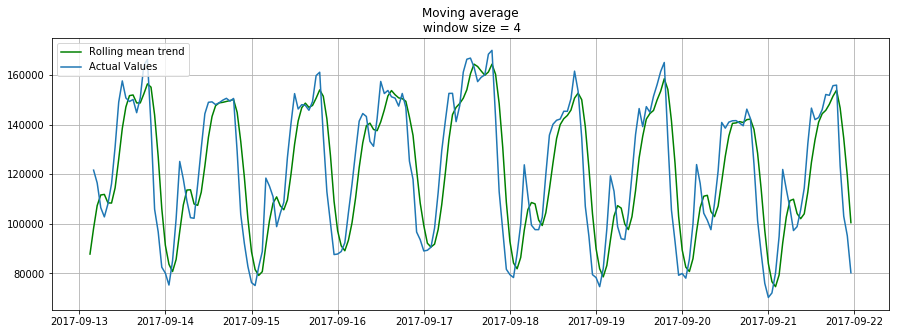

In [10]:
plotMovingAverage(ads, 4)

### Smoothing by last 12 hours

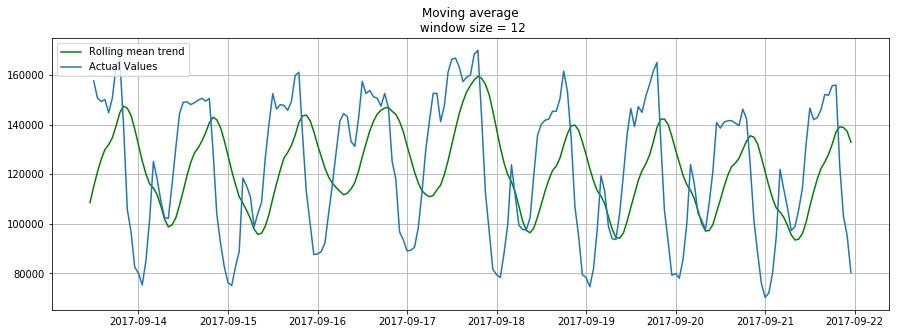

In [11]:
plotMovingAverage(ads, 12)

Smoothing by last 24 hours

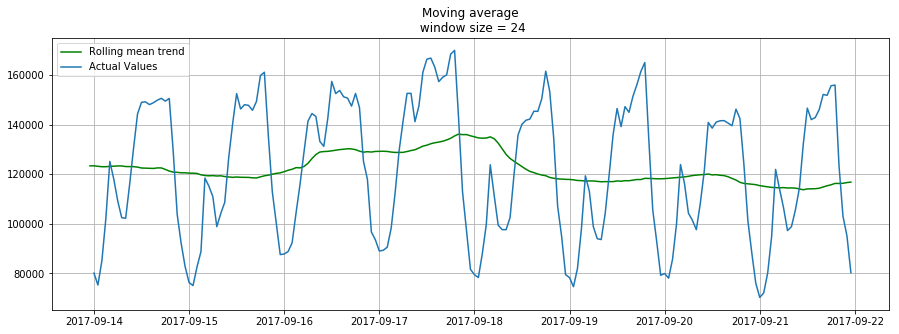

In [12]:
plotMovingAverage(ads, 24)

^daily average trends show that ads watched are the highest during the weekends

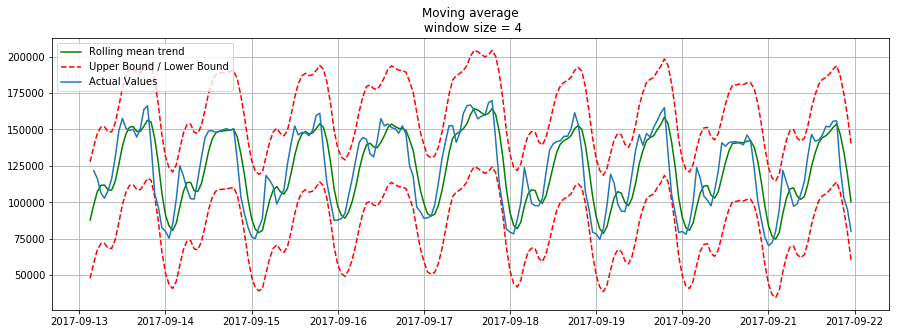

In [13]:
plotMovingAverage(ads, 4, plot_intervals =True)

^ 90% of the data is likely to fall within the lower and upper bounds

Now to build an anomaly detection system, we need more diverse data since our data is relatively normal.  So, let's just manually insert an abnormal value in the ```ads_anomaly``` dataframe

In [14]:
ads_anomaly = ads.copy()
ads_anomaly.iloc[-20] = ads_anomaly.iloc[-20]*.2  #we just manually dropped 80% of the ads on the given hour

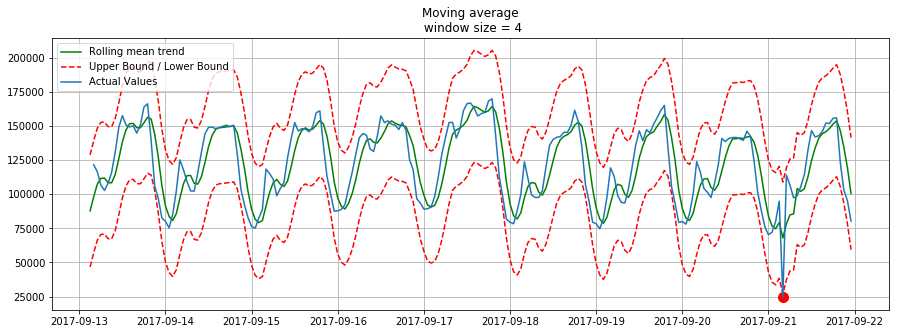

In [15]:
plotMovingAverage(ads_anomaly, 4, plot_intervals=True, plot_anomalies=True)

### Now let's do weekly smoothing on the currency data

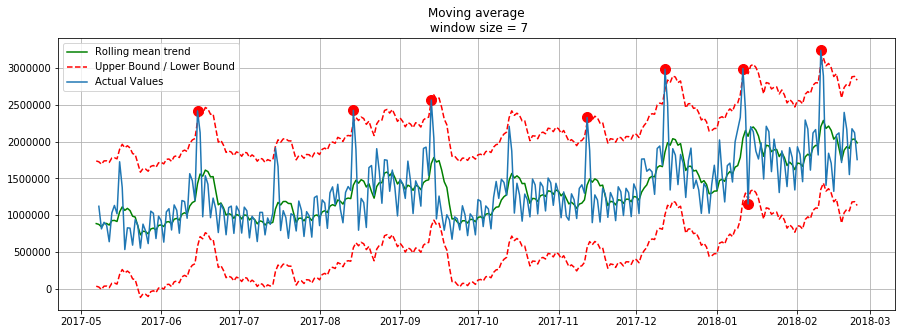

In [16]:
plotMovingAverage(currency, 7, plot_intervals=True, plot_anomalies=True)

^ The smoothing approach doesn't catch monthly seasonality in our data and marked almost all 30-day peaks as an anomaly.  

___

To build a more complex model, modify the moving average as a weighted moving average.  

In [17]:
def weighted_average(series, weights):
    result = 0.0
    weights.reverse()
    for n in range(len(weights)):
        result += series.iloc[-n-1]*weights[n]
    return float(result)

In [18]:
weighted_average(ads, [0.6, 0.3, 0.1])

98423.0

## Exponential Smoothing

Instead of weighting the last n values of the time series, we starting weighting all available observations while exponentially decreasing the weights as we move further back in historical data. 

y_pred = alpha * y_t + (1-alpha)* y_pred_t-1

^^ implicitly recursive, since we multiply (1-alpha) each time by the previous model value, which, in its turn also contains (1-alpha) and so forth until the very beginning


In [19]:
def exponential_smoothing(series, alpha):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha*series[n] + (1 - alpha)* result[n-1])
    return result

def plotExponentialSmoothing(series, alphas):
    with plt.style.context('seaborn-white'):
        plt.figure(figsize=(15,7))
        for alpha in alphas:
            plt.plot(exponential_smoothing(series,alpha), label=f"Alpha {alpha}")
        plt.plot(series.values, "c", label= "Actual")
        plt.legend(loc='best')
        plt.axis('tight')
        plt.title("exponential smoothing")
        plt.grid(True)

        

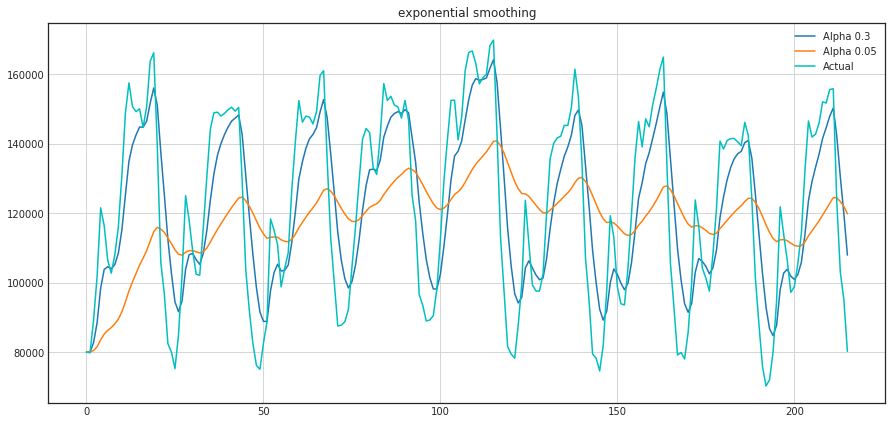

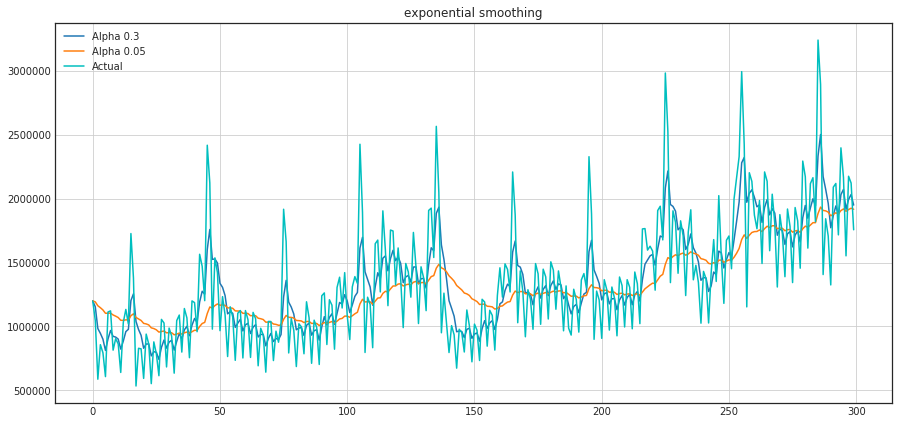

In [20]:
plotExponentialSmoothing(ads.Ads, [0.3, 0.05])
plotExponentialSmoothing(currency.GEMS_GEMS_SPENT, [0.3, 0.05])

## Double Exponential Smoothing

In [21]:
def double_exponential_smoothing(series, alpha, beta):
    """
    series - dataset with timeseries
    alpha - float [0.0, 1.0], smoothing parameter for level
    beta - float [0.0, 1.0], smoothing parameter for trend
    """
    result = [series[0]]
    for n in range(1, len(series)+1):
        if n ==1:
            level, trend = series[0], series[1]-series[0]
        if n >= len(series): # forecasting
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha*value + (1 - alpha)*(level+trend)
        trend = beta*(level - last_level) + (1 - beta)*trend
        result.append(level+trend)
    return result

def plotDoubleExponentialSmoothing(series,alphas, betas):
    with plt.style.context('seaborn-white'):
        plt.figure(figsize=(20,8))
        for alpha in alphas:
            for beta in betas:
                plt.plot(double_exponential_smoothing(series, alpha, beta), label=f"alpha {alpha}, beta {beta}")
        plt.plot(series.values, label="actual")
        plt.legend(loc='best')
        plt.axis('tight')
        plt.title("Double Exponential Smoothing")
        plt.grid(True)

    

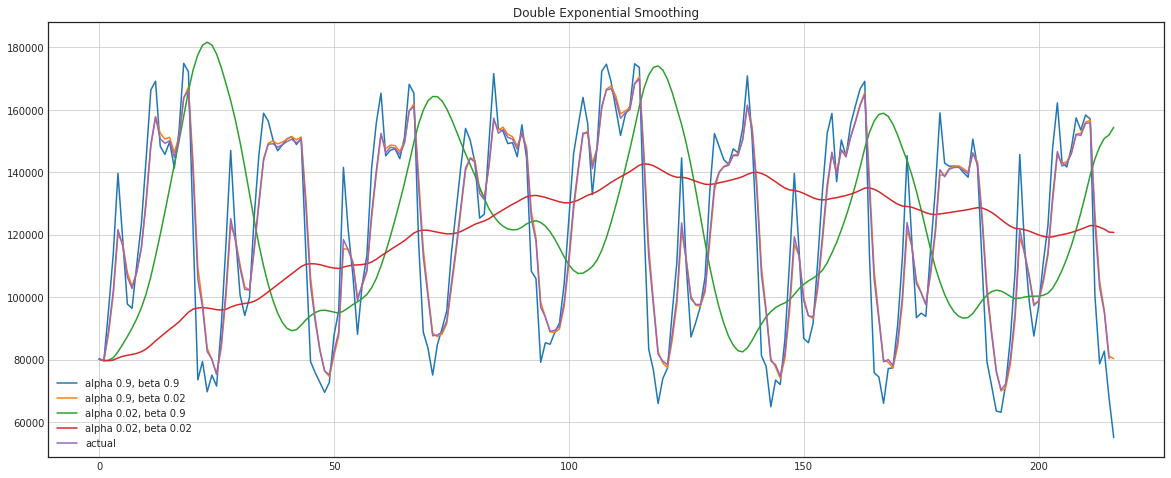

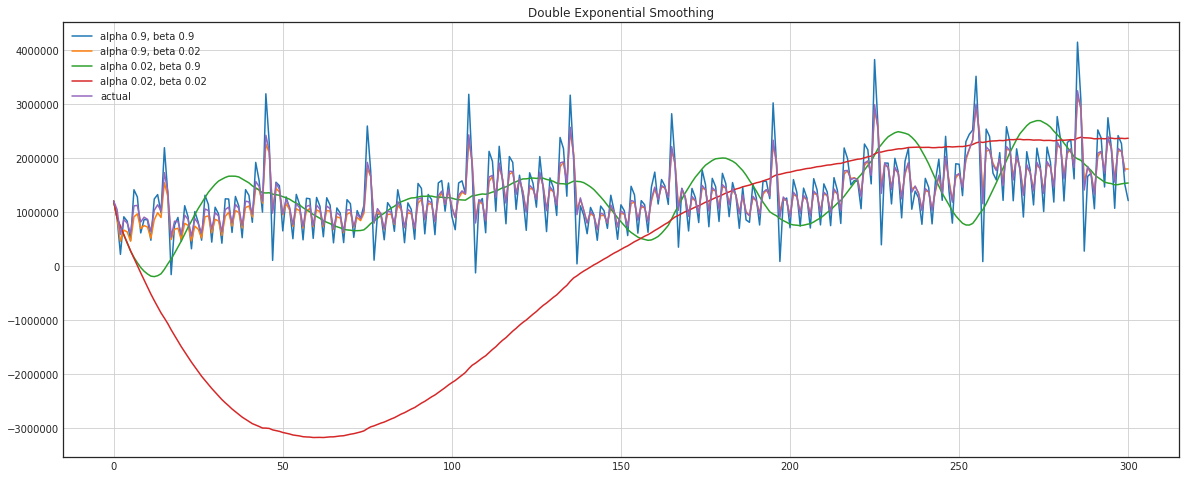

In [22]:
plotDoubleExponentialSmoothing(ads.Ads, alphas=[0.9, 0.02], betas=[0.9, 0.02])
plotDoubleExponentialSmoothing(currency.GEMS_GEMS_SPENT, alphas=[0.9, 0.02], betas = [0.9, 0.02])

In [24]:
class HoltWinters:
    """
    Holt-Winters Model with the anomalies detection using Brutlag method
    
    series - intitial time series
    slen - length of a season
    alpha, beta, gamma - Holt-Winters model coefficients
    n_preds - predictions horizon
    scaling_factor - stes the width of teh confidence interval by Brutlag (usually takes values from 2 to 3)
    
    """
    
    def __init__(self, series, slen, alpha, beta, gamma, n_preds, scaling_factor=1.96):
        self.series = series
        self.slen = slen
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.n_preds = n_preds
        self.scaling_factor = scaling_factor
    
    
    def initial_trend(self):
        sum = 0.0
        for i in range(self.slen):
            sum += float(self.series[i + self.slen] - self.series[i])/self.slen
        return sum/self.slen
    
    
    def initial_seasonal_components(self):
        seasonals = {}
        season_averages = []
        n_seasons = int(len(self.series)/self.slen)
        #calculate season averages
        for j in range(n_seasons):
            season_averages.append(sum(self.series[self.slen*j:self.slen*j+self.slen])/float(self.slen))
        #calculate initial values
        for i in range(self.slen):
            sum_of_vals_over_avg = 0.0
            for j in range(n_seasons):
                sum_of_vals_over_avg +=  self.series[self.slen*j + i] - season_averages[j]
            seasonals[i] = sum_of_vals_over_avg/n_seasons
        return seasonals
    
    
    def triple_exponential_smoothing(self):
        self.result = []
        self.Smooth = []
        self.Season = []
        self.Trend = []
        self.PredictedDeviation = []
        self.UpperBound = []
        self.LowerBound = []
        
        seasonals = self.initial_seasonal_components()
        
        for i in range(len(self.series)+ self.n_preds):
            if i == 0:  #components initialization
                smooth = self.series[0]
                trend = self.initial_trend()
                self.result.append(self.series[0])
                self.Smooth.append(smooth)
                self.Trend.append(trend)
                self.Season.append(seasonals[i%self.slen])
                
                self.PredictedDeviation.append(0)
                
                self.UpperBound.append(self.result[0] + self.scaling_factor*self.PredictedDeviation[0])
                
                self.LowerBound.append(self.result[0] - self.scaling_factor*self.PredictedDeviation[0])
                
                continue
            
            if i >= len(self.series):
                m = i - len(self.series) + 1
                self.result.append((smooth+m*trend)+seasonals[i%self.slen])
                self.PredictedDeviation.append(self.PredictedDeviation[-1]*1.01)
            
            else:
                val= self.series[i]
                last_smooth, smooth = smooth, self.alpha*(val-seasonals[i%self.slen]) + (1 - self.alpha)*(smooth+trend)
                trend = self.beta*(smooth-last_smooth) + (1-self.beta)*trend
                seasonals[i%self.slen] = self.gamma*(val-smooth)+ (1 - self.gamma)*seasonals[i%self.slen]
                self.result.append(smooth+trend+seasonals[i%self.slen])
                
                self.PredictedDeviation.append(self.gamma * np.abs(self.series[i]-self.result[i])
                                              + (1-self.gamma)*self.PredictedDeviation[-1])
            
            self.UpperBound.append(self.result[-1] + self.scaling_factor*self.PredictedDeviation[-1])
            
            self.LowerBound.append(self.result[-1] - self.scaling_factor*self.PredictedDeviation[-1])
            
            self.Smooth.append(smooth)
            self.Trend.append(trend)
            self.Season.append(seasonals[i%self.slen])
                







## Time series cross validation

As always, choose a loss function, calculate gradient, adjust model parameters and so forth, descending to the global minimum error.

How to do cross validation on time series.... 
* you can't just randomly mix values
* train on small segment of time series, from the beginning up to some point t --> make predictions for the next t+n steps and calculate the error.
* then, we expand our training sample until t+n value and make predictions from t+n until t+2n, and we continue moving out test segment of teh time series until we hit the last available obs.
* As a result, we have as many folds as many n will fit between the intial training sample and the last obs.


![picture](cv_time_series.png)



In [25]:
from sklearn.model_selection import TimeSeriesSplit

def timeseriesCVscore(params, series, loss_function=mean_squared_error, slen=24):
    """
    Returns error on CV
    params - vector of parameters for optimization
    series - dataset with timeseries
    slen - season length for holt-winters model
    """
    #errors array
    errors = []
    
    values = series.values
    alpha, beta, gamma = params
    
    tscv = TimeSeriesSplit(n_splits = 3)
    
    # iterating over folds, train model on each, forecast and calculate error
    for train, test in tscv.split(values):
        model = HoltWinters(series=values[train], slen=slen, 
                           alpha=alpha, beta=beta, gamma=gamma, n_preds=len(test))
        model.triple_exponential_smoothing()
        
        predictions = model.result[-len(test):]
        actual = values[test]
        error = loss_function(predictions, actual)
        errors.append(error)
    
    return np.mean(np.array(errors))

In [27]:
%%time
data = ads.Ads[:-20] #leave some data for testing

#initializing alpha, beta, gamma
x = [0,0,0]

#Minimizing the loss function TNC = Truncated Newton Conjugate
opt = minimize(timeseriesCVscore, x0=x, args=(data, mean_squared_log_error), 
              method="TNC", bounds = ((0, 1), (0, 1), (0, 1)))

#take optimal values
alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)

#..and train teh model with them, forecasting for the next 50 hours
model = HoltWinters(data, slen = 24, alpha = alpha_final, beta=beta_final,
                    gamma= gamma_final, n_preds=50, scaling_factor = 3)

model.triple_exponential_smoothing()



0.11652680227350454 0.002677697431105852 0.05820973606789237
CPU times: user 1.32 s, sys: 0 ns, total: 1.32 s
Wall time: 1.31 s


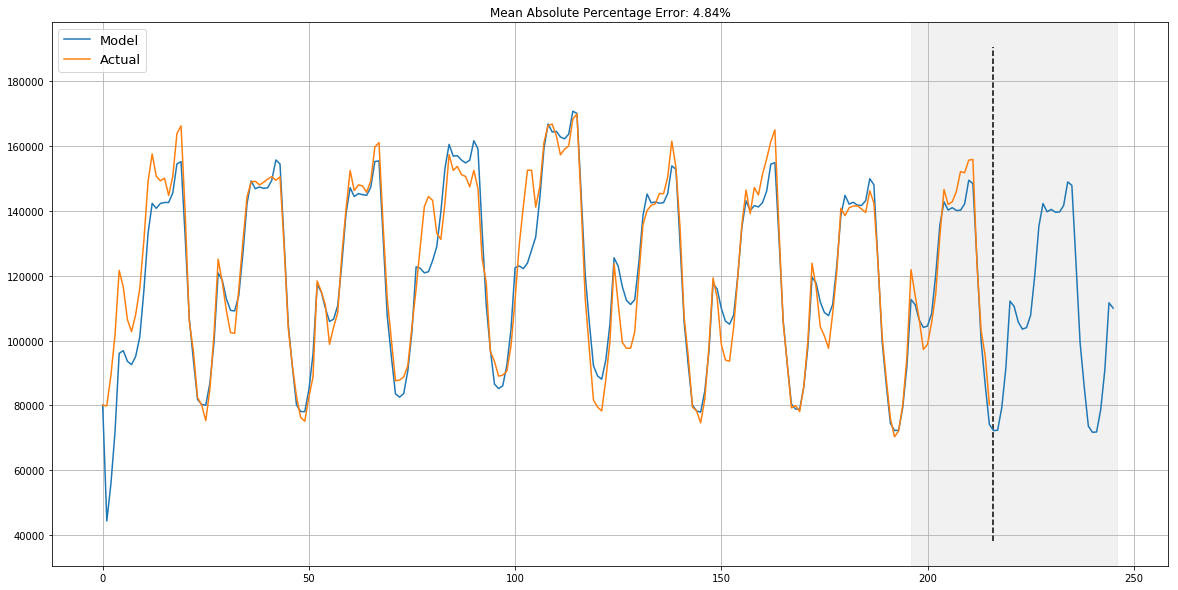

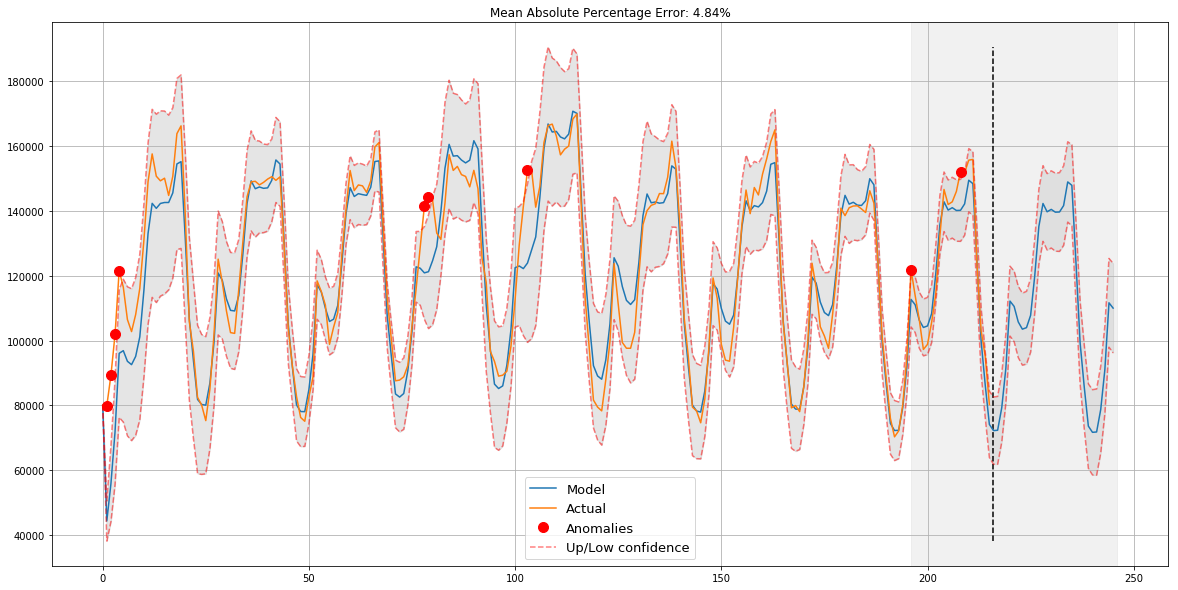

In [28]:
def plotHoltWinters(series, plot_intervals=False, plot_anomalies=False):
    """
    series - dataset w timeseries
    plot_intervals - show confidence intervals
    plot_anomalies - show anomalies
    """
    plt.figure(figsize=(20,10))
    plt.plot(model.result, label = "Model")
    plt.plot(series.values, label = "Actual")
    error = mean_absolute_percentage_error(series.values, model.result[:len(series)])
    plt.title(f"Mean Absolute Percentage Error: {error:.2f}%")
    
    if plot_anomalies:
        anomalies= np.array([np.NaN]*len(series))
        anomalies[series.values<model.LowerBound[:len(series)]] = series.values[
            series.values<model.LowerBound[:len(series)]]
        anomalies[series.values>model.UpperBound[:len(series)]] = series.values[
            series.values>model.UpperBound[:len(series)]]
        plt.plot(anomalies, "ro", markersize=10, label = "Anomalies")
    
    if plot_intervals:
        plt.plot(model.UpperBound, "r--", alpha=0.5, label = "Up/Low confidence")
        plt.plot(model.LowerBound, "r--", alpha=0.5)
        plt.fill_between(x=range(0, len(model.result)), y1=model.UpperBound, 
                        y2=model.LowerBound, alpha=0.2, color = "grey")
    
    plt.vlines(len(series), ymin=min(model.LowerBound), ymax=max(model.UpperBound),
              linestyle='dashed')
    plt.axvspan(len(series)-20, len(model.result), alpha=0.3, color='lightgrey')
    plt.grid(True)
    plt.axis('tight')
    plt.legend(loc='best', fontsize=13)

plotHoltWinters(ads.Ads)
plotHoltWinters(ads.Ads, plot_intervals=True, plot_anomalies=True)

Text(0.5,1,"Brutlag's predicted deviation")

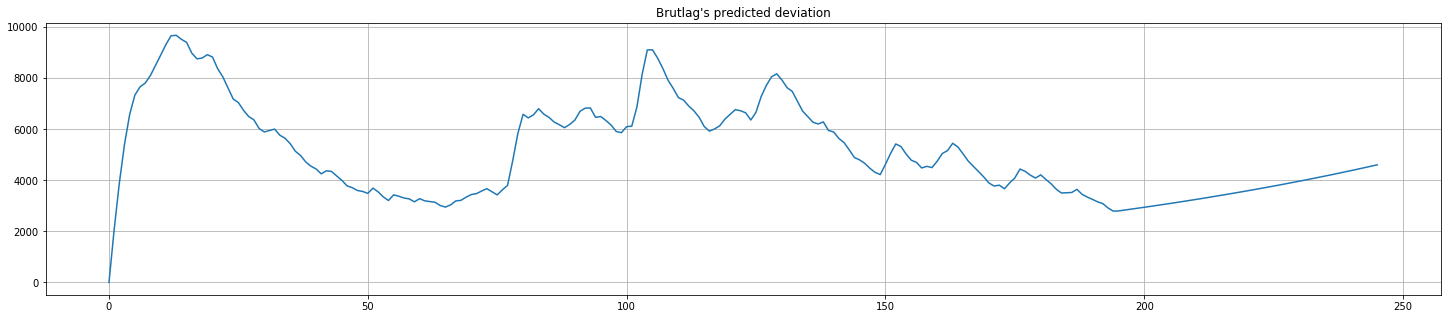

In [29]:
plt.figure(figsize=(25,5))
plt.plot(model.PredictedDeviation)
plt.grid(True)
plt.axis('tight')
plt.title("Brutlag's predicted deviation")

In [30]:
%%time
data = currency.GEMS_GEMS_SPENT[:-50]
slen = 30

x = [0, 0, 0]

opt = minimize(timeseriesCVscore, x0=x, args=(data, mean_absolute_percentage_error,slen),
              method="TNC", bounds = ((0,1), (0,1), (0, 1)))

alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)

model = HoltWinters(data, slen=slen, alpha=alpha_final, beta=beta_final, gamma=gamma_final, 
                   n_preds=100, scaling_factor=3)

model.triple_exponential_smoothing()

0.012841445048055122 0.04883371471892228 0.00943678056045777
CPU times: user 2.15 s, sys: 0 ns, total: 2.15 s
Wall time: 2.13 s


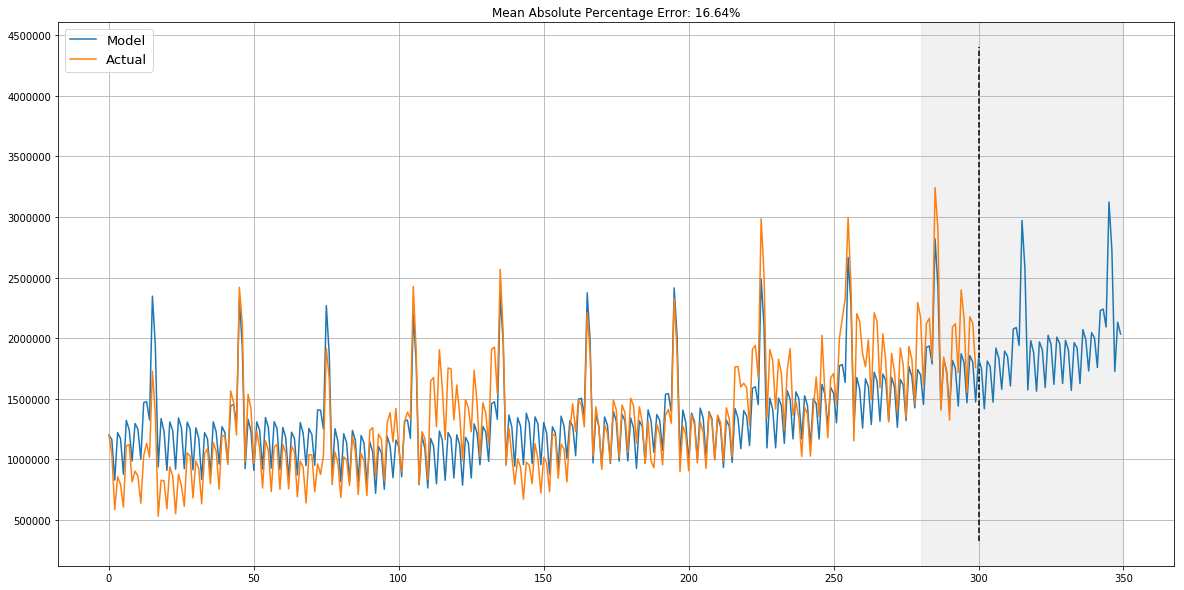

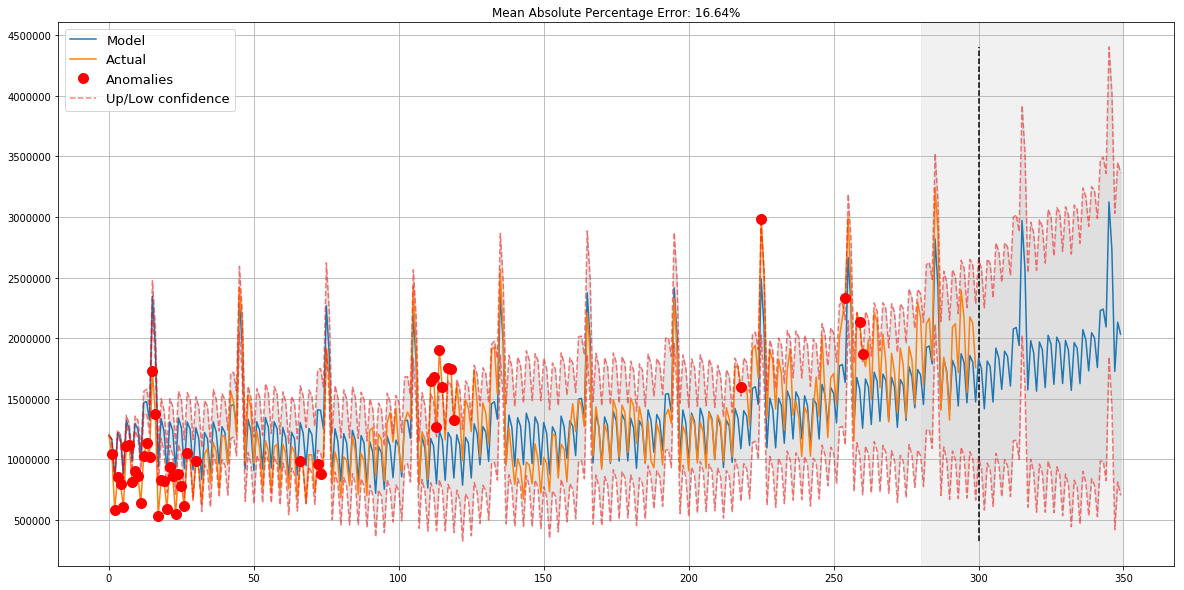

In [31]:
plotHoltWinters(currency.GEMS_GEMS_SPENT)
plotHoltWinters(currency.GEMS_GEMS_SPENT, plot_intervals=True, plot_anomalies=True)

Text(0.5,1,"Brutlag's predicted deviation")

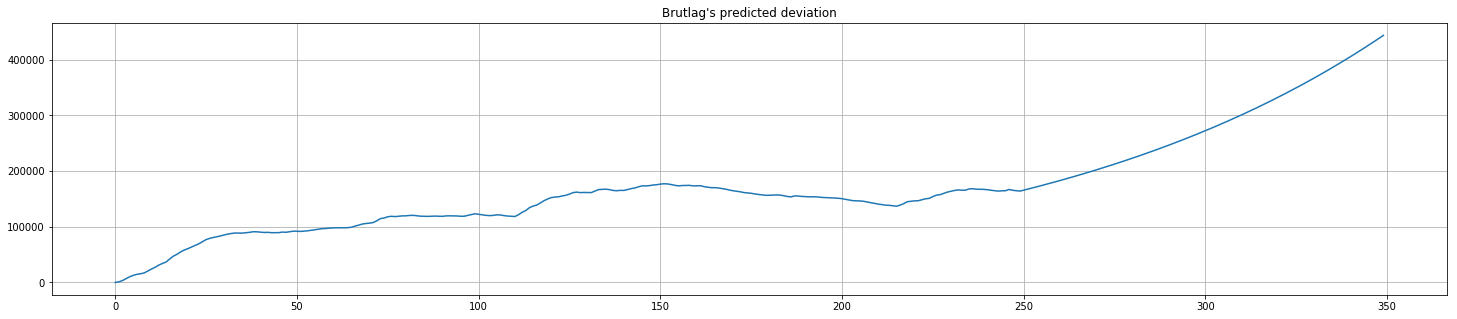

In [32]:
plt.figure(figsize=(25,5))
plt.plot(model.PredictedDeviation)
plt.grid(True)
plt.axis('tight')
plt.title("Brutlag's predicted deviation")

## Econometric Approach

**Stationarity** means process doesn't changes its statistical properties over time, namely mean and variance don't change over time (constancy of variance is also called homoscedasticity).

How do you detect stationarity?

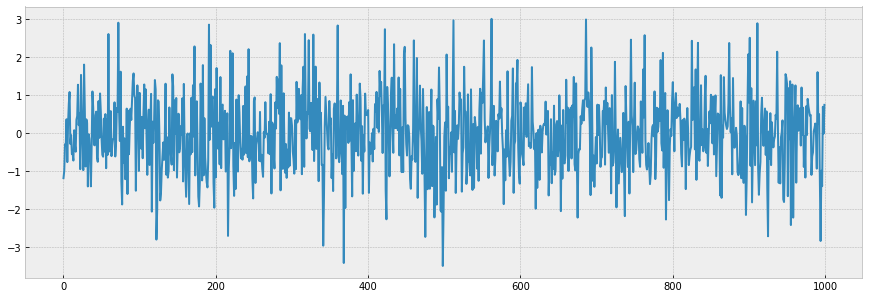

In [33]:
#Make white noise
white_noise = np.random.normal(size=1000)
with plt.style.context('bmh'):
    plt.figure(figsize=(15,5))
    plt.plot(white_noise)

^ This plot is stationary and oscillates around zero with devation of 1

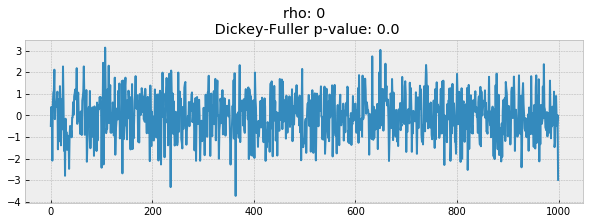

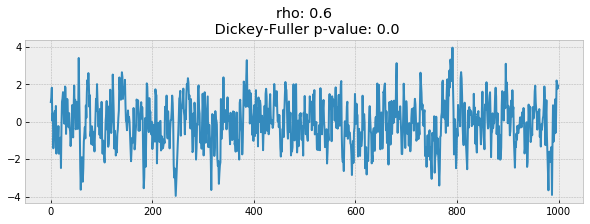

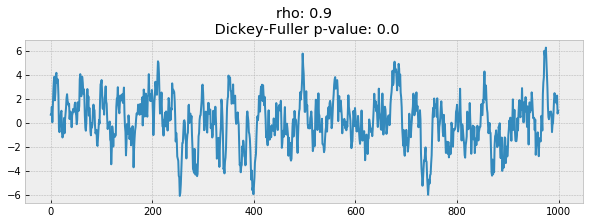

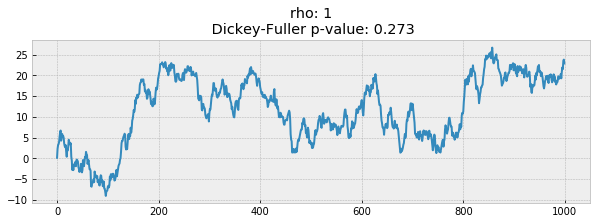

In [35]:
def plotProcess(n_samples=1000, rho=0):
    x = w = np.random.normal(size=n_samples)
    for t in range(n_samples):
        x[t] = rho*x[t-1] + w[t]
    
    with plt.style.context('bmh'):
        plt.figure(figsize=(10, 3))
        plt.plot(x)
        plt.title(f'rho: {rho}\n Dickey-Fuller p-value: {round(sm.tsa.stattools.adfuller(x)[1],3)}') #sm = statsmodels.api
    

for rho in [0, 0.6, 0.9, 1]:
    plotProcess(rho=rho)
                  

_____
Building an ARIMA model (AutoRegressive Integrating Moving Average)

In [38]:
def tsplot(y, lags=None, figsize=(12,7), style = 'bmh'):
    """
    lags = how many lags to includ in ACF, PACF calculations
    """
    if not isinstance(y, pd.Series):
        y=pd.Series(y)
    with plt.style.context(style):
        fig = plt.figure(figsize=figsize)
        layout = (2,2)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (1,1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title(f"Time Series Analysis Plots\n Dickey Fuller: p = {p_value}")
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()



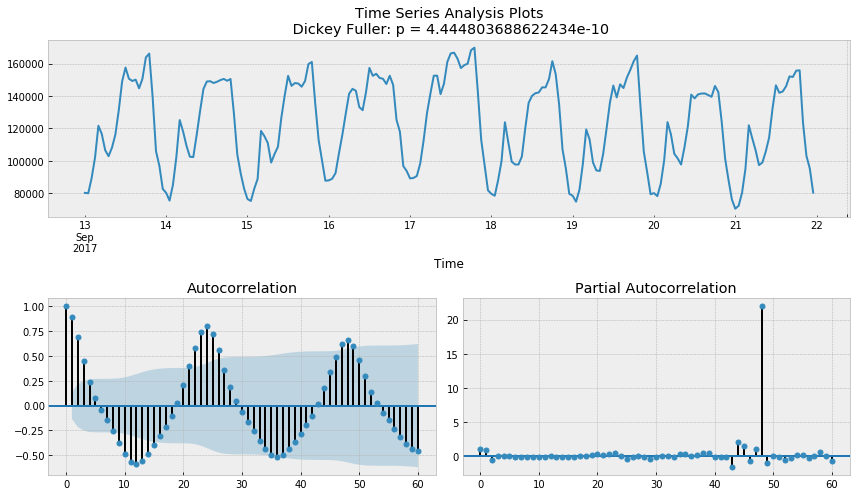

In [39]:
tsplot(ads.Ads, lags=60)

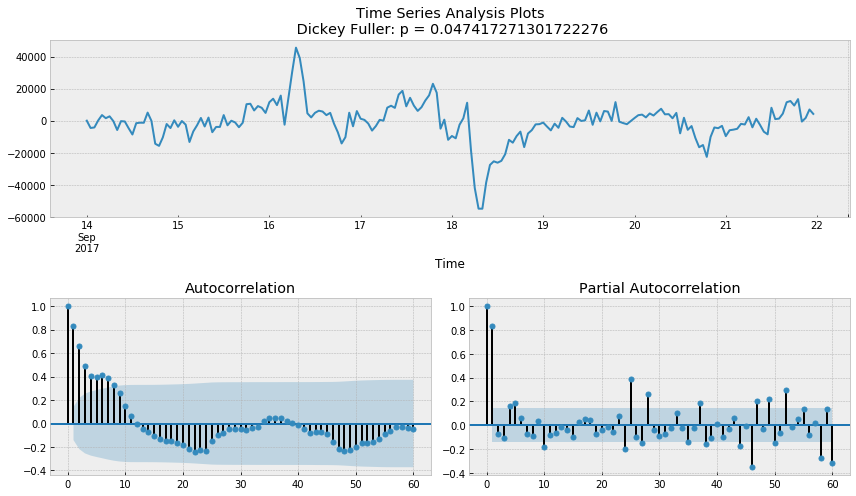

In [49]:
ads_diff = ads.Ads - ads.Ads.shift(24)
tsplot(ads_diff[24:], lags=60)
#The seasonality difference here is the following: today's ith hour - yesterday's ith hour 

In [44]:
ads_diff

Time
2017-09-13 00:00:00        NaN
2017-09-13 01:00:00        NaN
2017-09-13 02:00:00        NaN
2017-09-13 03:00:00        NaN
2017-09-13 04:00:00        NaN
2017-09-13 05:00:00        NaN
2017-09-13 06:00:00        NaN
2017-09-13 07:00:00        NaN
2017-09-13 08:00:00        NaN
2017-09-13 09:00:00        NaN
2017-09-13 10:00:00        NaN
2017-09-13 11:00:00        NaN
2017-09-13 12:00:00        NaN
2017-09-13 13:00:00        NaN
2017-09-13 14:00:00        NaN
2017-09-13 15:00:00        NaN
2017-09-13 16:00:00        NaN
2017-09-13 17:00:00        NaN
2017-09-13 18:00:00        NaN
2017-09-13 19:00:00        NaN
2017-09-13 20:00:00        NaN
2017-09-13 21:00:00        NaN
2017-09-13 22:00:00        NaN
2017-09-13 23:00:00        NaN
2017-09-14 00:00:00       10.0
2017-09-14 01:00:00    -4550.0
2017-09-14 02:00:00    -4220.0
2017-09-14 03:00:00      150.0
2017-09-14 04:00:00     3505.0
2017-09-14 05:00:00     1555.0
                        ...   
2017-09-20 18:00:00   -15170.0
201

In [45]:
ads.Ads

Time
2017-09-13 00:00:00     80115
2017-09-13 01:00:00     79885
2017-09-13 02:00:00     89325
2017-09-13 03:00:00    101930
2017-09-13 04:00:00    121630
2017-09-13 05:00:00    116475
2017-09-13 06:00:00    106495
2017-09-13 07:00:00    102795
2017-09-13 08:00:00    108055
2017-09-13 09:00:00    116125
2017-09-13 10:00:00    131030
2017-09-13 11:00:00    149020
2017-09-13 12:00:00    157590
2017-09-13 13:00:00    150715
2017-09-13 14:00:00    149295
2017-09-13 15:00:00    150100
2017-09-13 16:00:00    144780
2017-09-13 17:00:00    150690
2017-09-13 18:00:00    163840
2017-09-13 19:00:00    166235
2017-09-13 20:00:00    139520
2017-09-13 21:00:00    105895
2017-09-13 22:00:00     96780
2017-09-13 23:00:00     82520
2017-09-14 00:00:00     80125
2017-09-14 01:00:00     75335
2017-09-14 02:00:00     85105
2017-09-14 03:00:00    102080
2017-09-14 04:00:00    125135
2017-09-14 05:00:00    118030
                        ...  
2017-09-20 18:00:00    146215
2017-09-20 19:00:00    142425
2017-

In [46]:
ads.Ads.shift(24)

Time
2017-09-13 00:00:00         NaN
2017-09-13 01:00:00         NaN
2017-09-13 02:00:00         NaN
2017-09-13 03:00:00         NaN
2017-09-13 04:00:00         NaN
2017-09-13 05:00:00         NaN
2017-09-13 06:00:00         NaN
2017-09-13 07:00:00         NaN
2017-09-13 08:00:00         NaN
2017-09-13 09:00:00         NaN
2017-09-13 10:00:00         NaN
2017-09-13 11:00:00         NaN
2017-09-13 12:00:00         NaN
2017-09-13 13:00:00         NaN
2017-09-13 14:00:00         NaN
2017-09-13 15:00:00         NaN
2017-09-13 16:00:00         NaN
2017-09-13 17:00:00         NaN
2017-09-13 18:00:00         NaN
2017-09-13 19:00:00         NaN
2017-09-13 20:00:00         NaN
2017-09-13 21:00:00         NaN
2017-09-13 22:00:00         NaN
2017-09-13 23:00:00         NaN
2017-09-14 00:00:00     80115.0
2017-09-14 01:00:00     79885.0
2017-09-14 02:00:00     89325.0
2017-09-14 03:00:00    101930.0
2017-09-14 04:00:00    121630.0
2017-09-14 05:00:00    116475.0
                         ...   
201

^^ visible seasonality is gone, but autocorrelation function has too many significant lags. So let's remove them by taking the first differences

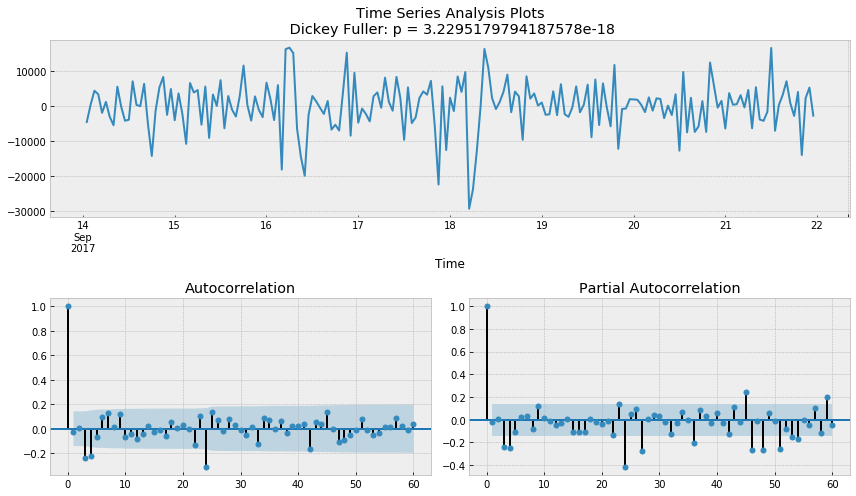

In [50]:
ads_diff = ads_diff - ads_diff.shift(1)
tsplot(ads_diff[24+1:], lags=60)

## ARIMA-family

* AR(p) -- autoregression model, where p is maximum lag. To determine p, you need to look at PACF plot where you find the biggest significant lag, after which most other lags are becoming not significant
* MA(q) -- autoregression model, where q is error.  Initial value van be found on ACF plot.
* I(d) -- order of integration.  The number of nonseasonal differences needed for making the series stationary.  
* S(s) -- the season period length of the series


In [51]:
ps = range(2, 5)
d = 1
qs = range(2, 5)
Ps = range(0,3)
D = 1
Qs= range(0,2)
s = 24

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)


54

In [57]:
def optimizeSARIMA(parameters_list, d, D, s):
    """
    Return dataframe with parameters and corresponding AIC
    
    parameters_list - list with (p, q, P, Q) tuples
    d - integration order in ARIMA 
    D - seasonal integration order
    s - length of season
    """
    
    results = []
    best_aic= float("inf")
    
    for param in tqdm_notebook(parameters_list):
        try:
            model = sm.tsa.statespace.SARIMAX(ads.Ads, order = (param[0], d, param[1]),
                                             seasonal_order = (param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
        aic = model.aic
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])
    
    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

%time
result_table = optimizeSARIMA(parameters_list, d, D, s)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 8.11 µs


In [58]:
p, q, P, Q = result_table.parameters[0]
best_model = sm.tsa.statespace.SARIMAX(ads.Ads, order=(p, d, q), seasonal_order = (P, D, Q, s)).fit(disp=-1)

In [59]:
best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                Ads   No. Observations:                  216
Model:             SARIMAX(2, 1, 3)x(1, 1, 1, 24)   Log Likelihood               -1936.321
Date:                            Mon, 28 Jan 2019   AIC                           3888.642
Time:                                    15:33:37   BIC                           3914.660
Sample:                                09-13-2017   HQIC                          3899.181
                                     - 09-21-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7913      0.270      2.928      0.003       0.262       1.321
ar.L2         -0.5503      0.306     -1.799      0.072      -1.150       0.049
ma.L1         -0.7316      0.262     -2.793      0.005      -1.245      -0.218
ma.L2          0.5651      0.282      2.005      0.045       0.013       1.118
ma.L3         -0.1811      0.092     -1.964      0.049      -0.362      -0.000
ar.S.L24       0.3312      0.076      4.351      0.000       0.182       0.480
ma.S.L24      -0.7635      0.104     -7.361      0.000      -0.967      -0.560
sigma2      4.574e+07   5.61e-09   8.15e+15      0.000    4.57e+07    4.57e+07
===================================================================================
Ljung-Box (Q):                       43.70   Jarque-Bera (JB):                10.56
Prob(Q):                              0.32   Prob(JB):                         0.01
Heteroskedasticity (H):               0.65   Skew:                            -0.28
Prob(H) (two-sided):                  0.09   Kurtosis:                         4.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.71e+32. Standard errors may be unstable.
"""

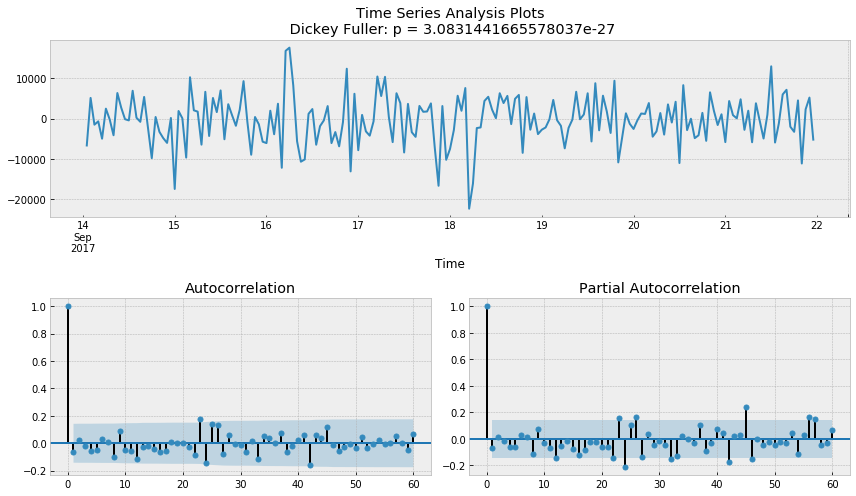

In [60]:
tsplot(best_model.resid[25:], lags=60)

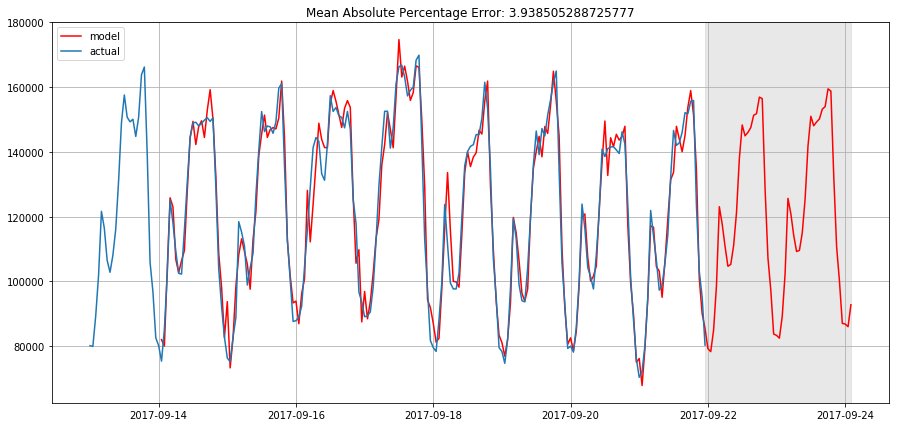

In [61]:
def plotSARIMA(series, model, n_steps):
    data = series.copy()
    data.columns = ['actual']
    data['arima_model'] = model.fittedvalues
    data['arima_model'][:s+d] = np.NaN
    
    forecast = model.predict(start = data.shape[0], end = data.shape[0]+n_steps)
    forecast = data.arima_model.append(forecast)
    error = mean_absolute_percentage_error(data['actual'][s+d:], data['arima_model'][s+d:])
    
    plt.figure(figsize=(15, 7))
    plt.title(f"Mean Absolute Percentage Error: {error}")
    plt.plot(forecast, color='r', label='model')
    plt.axvspan(data.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
    plt.plot(data.actual, label='actual')
    plt.legend()
    plt.grid(True);
    
plotSARIMA(ads,best_model, 50)

SARIMA has many parameters to turn --> frequent retraining on new data --> not production ready.

Try using random forests or linear regression. Although this violates the assumption that the sample is IID, but still may be practical and better.

With 1D time series data, what can you extract:
* lags (super hard to determine sometimes; many lags -- good since you have more data to use in your model, bad since it can't catch short term changes from unobserved period.)
* window stats (max/min, avg, var, etc)
* data and time features (holiday? evening?, morning?, afternoon?, weekend?)
* forecasts from other models




## How to find balance b/w optimal prediction quality and length of forecasting horizon AKA how to find lags

In [62]:
data = pd.DataFrame(ads.Ads.copy())
data.columns = ["y"]
for i in range(6, 25):
    data[f"lag_{i}"] = data.y.shift(i)

In [63]:
data

y     lag_6     lag_7     lag_8     lag_9    lag_10  \
Time                                                                            
2017-09-13 00:00:00   80115       NaN       NaN       NaN       NaN       NaN   
2017-09-13 01:00:00   79885       NaN       NaN       NaN       NaN       NaN   
2017-09-13 02:00:00   89325       NaN       NaN       NaN       NaN       NaN   
2017-09-13 03:00:00  101930       NaN       NaN       NaN       NaN       NaN   
2017-09-13 04:00:00  121630       NaN       NaN       NaN       NaN       NaN   
2017-09-13 05:00:00  116475       NaN       NaN       NaN       NaN       NaN   
2017-09-13 06:00:00  106495   80115.0       NaN       NaN       NaN       NaN   
2017-09-13 07:00:00  102795   79885.0   80115.0       NaN       NaN       NaN   
2017-09-13 08:00:00  108055   89325.0   79885.0   80115.0       NaN       NaN   
2017-09-13 09:00:00  116125  101930.0   89325.0   79885.0   80115.0       NaN   
2017-09-13 10:00:00  131030  121630.0  101930.0   89325.0   79885.0   80115.0   
2017-09-13 11:00:00  149020  116475.0  121630.0  101930.0   89325.0   79885.0   
2017-09-13 12:00:00  157590  106495.0  116475.0  121630.0  101930.0   89325.0   
2017-09-13 13:00:00  150715  102795.0  106495.0  116475.0  121630.0  101930.0   
2017-09-13 14:00:00  149295  108055.0  102795.0  106495.0  116475.0  121630.0   
2017-09-13 15:00:00  150100  116125.0  108055.0  102795.0  106495.0  116475.0   
2017-09-13 16:00:00  144780  131030.0  116125.0  108055.0  102795.0  106495.0   
2017-09-13 17:00:00  150690  149020.0  131030.0  116125.0  108055.0  102795.0   
2017-09-13 18:00:00  163840  157590.0  149020.0  131030.0  116125.0  108055.0   
2017-09-13 19:00:00  166235  150715.0  157590.0  149020.0  131030.0  116125.0   
2017-09-13 20:00:00  139520  149295.0  150715.0  157590.0  149020.0  131030.0   
2017-09-13 21:00:00  105895  150100.0  149295.0  150715.0  157590.0  149020.0   
2017-09-13 22:00:00   96780  144780.0  150100.0  149295.0  150715.0  157590.0   
2017-09-13 23:00:00   82520  150690.0  144780.0  150100.0  149295.0  150715.0   
2017-09-14 00:00:00   80125  163840.0  150690.0  144780.0  150100.0  149295.0   
2017-09-14 01:00:00   75335  166235.0  163840.0  150690.0  144780.0  150100.0   
2017-09-14 02:00:00   85105  139520.0  166235.0  163840.0  150690.0  144780.0   
2017-09-14 03:00:00  102080  105895.0  139520.0  166235.0  163840.0  150690.0   
2017-09-14 04:00:00  125135   96780.0  105895.0  139520.0  166235.0  163840.0   
2017-09-14 05:00:00  118030   82520.0   96780.0  105895.0  139520.0  166235.0   
...                     ...       ...       ...       ...       ...       ...   
2017-09-20 18:00:00  146215  138555.0  140850.0  121250.0  108265.0   97635.0   
2017-09-20 19:00:00  142425  140990.0  138555.0  140850.0  121250.0  108265.0   
2017-09-20 20:00:00  123945  141525.0  140990.0  138555.0  140850.0  121250.0   
2017-09-20 21:00:00  101360  141590.0  141525.0  140990.0  138555.0  140850.0   
2017-09-20 22:00:00   88170  140610.0  141590.0  141525.0  140990.0  138555.0   
2017-09-20 23:00:00   76050  139515.0  140610.0  141590.0  141525.0  140990.0   
2017-09-21 00:00:00   70335  146215.0  139515.0  140610.0  141590.0  141525.0   
2017-09-21 01:00:00   72150  142425.0  146215.0  139515.0  140610.0  141590.0   
2017-09-21 02:00:00   80195  123945.0  142425.0  146215.0  139515.0  140610.0   
2017-09-21 03:00:00   94945  101360.0  123945.0  142425.0  146215.0  139515.0   
2017-09-21 04:00:00  121910   88170.0  101360.0  123945.0  142425.0  146215.0   
2017-09-21 05:00:00  113950   76050.0   88170.0  101360.0  123945.0  142425.0   
2017-09-21 06:00:00  106495   70335.0   76050.0   88170.0  101360.0  123945.0   
2017-09-21 07:00:00   97290   72150.0   70335.0   76050.0   88170.0  101360.0   
2017-09-21 08:00:00   98860   80195.0   72150.0   70335.0   76050.0   88170.0   
2017-09-21 09:00:00  105635   94945.0   80195.0   72150.0   70335.0   76050.0   
2017-09-21 10:00:00  114380  121910.0   94945.0   80195.0

In [74]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

tscv = TimeSeriesSplit(n_splits = 5)

def timeseries_train_test_split(X, y, test_size):
    
    test_index = int(len(X)*(1-test_size))
    
    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]
    
    return X_train, X_test, y_train, y_test


def plotModelResults(model, X_train=X_train, X_test=X_test, plot_intervals=False, plot_anomalies= False, scale = 1.96):
    prediction = model.predict(X_test)
    
    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "g", label = "Prediction", linewidth=2.0)
    plt.plot(y_test.values, label = "Actual", linewidth =2.0)
    
    if plot_intervals:
        cv = cross_val_score(model, X_train, y_train, cv=tscv, scoring = "neg_mean_squared_error")
        deviation = np.sqrt(cv.std())
        
        lower = prediction - scale*deviation
        upper = prediction + scale*deviation
        
        plt.plot(lower, "r--", label="upper bound/lower bound", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)
        
    if plot_anomalies:
        anomalies = np.array([np.NaN]*len(y_test))
        anomalies[y_test<lower] = y_test[y_test<lower]
        anomalies[y_test>upper]=y_test[y_test>upper]
        plt.plot(anomalies, "o", markersize=10, label="anomalies")
    
    error = mean_absolute_percentage_error(prediction, y_test)
    plt.title(f"mean absolute percentage error {error}")
    plt.legend(loc='best')
    plt.tight_layout()
    plt.grid(True)


def plotCoefficients(model):
    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by='abs', ascending=False).drop(["abs"], axis=1)
    
    plt.figure(figsize=(15,7))
    coefs.coef.plot(kind='bar')
    plt.grid(True)
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed')

    
    

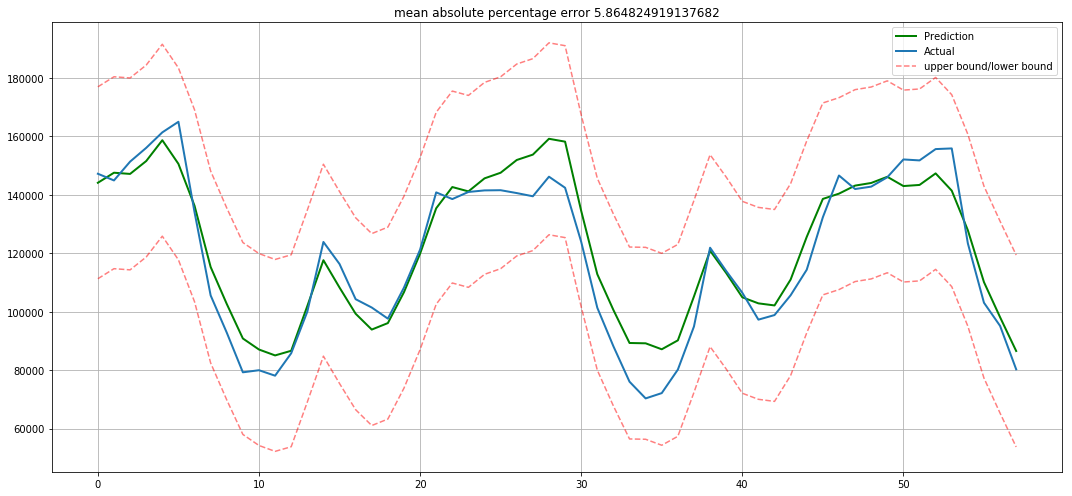

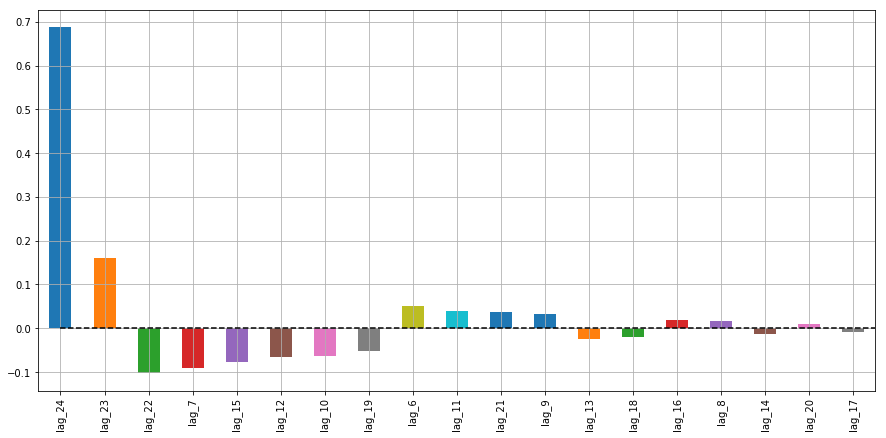

In [75]:
y = data.dropna().y
X = data.dropna().drop(['y'], axis=1)

X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)

lr = LinearRegression()
lr.fit(X_train, y_train)


plotModelResults(lr, plot_intervals=True)
plotCoefficients(lr)

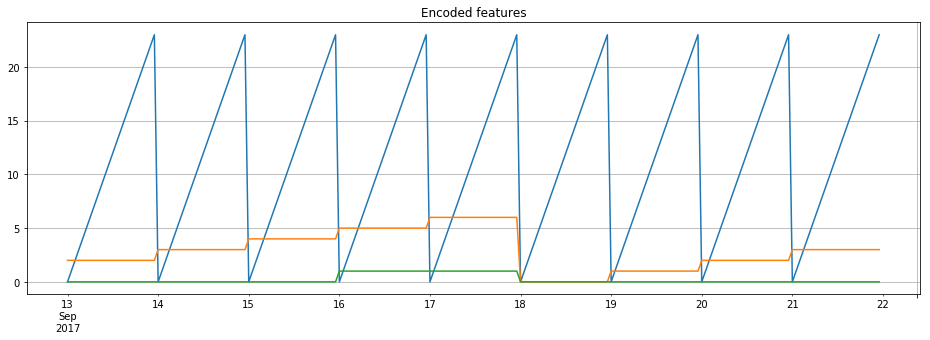

In [79]:
data.index = data.index.to_pydatetime()
data["hour"] = data.index.hour
data["weekday"] = data.index.weekday
data['is_weekend'] = data.weekday.isin([5,6])*1

plt.figure(figsize=(16,5))
plt.title("Encoded features")
data.hour.plot()
data.weekday.plot()
data.is_weekend.plot()
plt.grid(True)

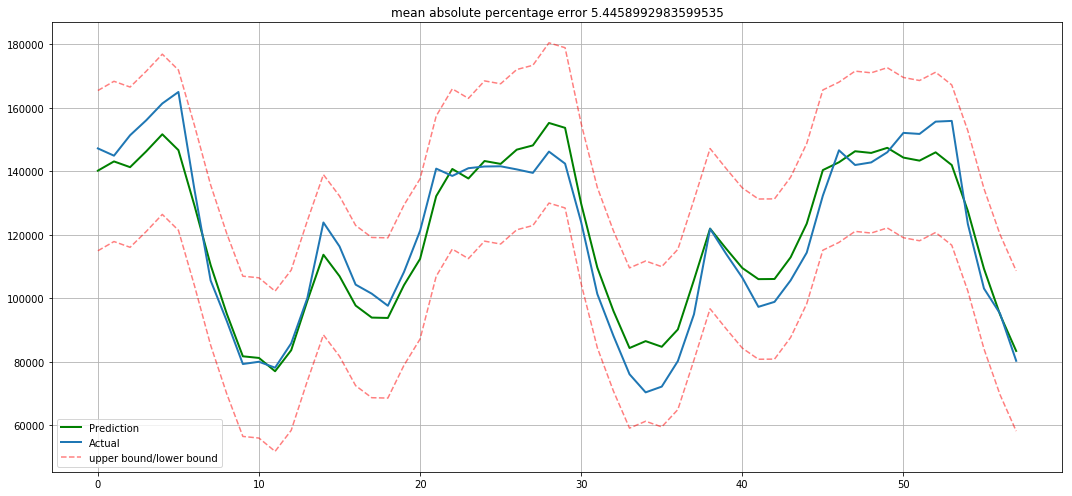

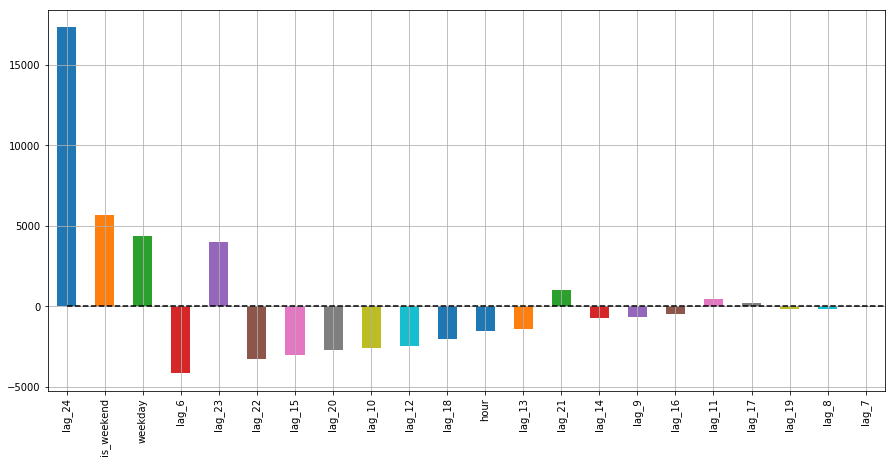

In [80]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

y = data.dropna().y
X = data.dropna().drop(['y'], axis=1)

X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

plotModelResults(lr, X_train=X_train_scaled, X_test=X_test_scaled, plot_intervals=True)
plotCoefficients(lr)

In [81]:
def code_mean(data, cat_feature, real_feature):
    return dict(data.groupby(cat_feature)[real_feature].mean())

{0: 80178.88888888889,
 1: 79091.11111111111,
 2: 86223.33333333333,
 3: 98695.0,
 4: 120291.11111111111,
 5: 118093.33333333333,
 6: 113172.77777777778,
 7: 110168.33333333333,
 8: 110902.22222222222,
 9: 115071.11111111111,
 10: 126923.33333333333,
 11: 142477.77777777778,
 12: 150500.0,
 13: 147700.0,
 14: 148446.11111111112,
 15: 148116.66666666666,
 16: 148832.77777777778,
 17: 150643.88888888888,
 18: 157628.88888888888,
 19: 156817.22222222222,
 20: 132030.55555555556,
 21: 107847.22222222222,
 22: 94936.11111111111,
 23: 82589.44444444444}

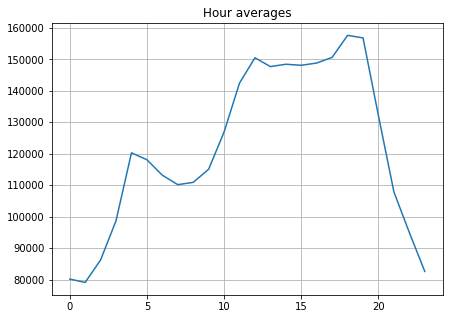

In [83]:
average_hour = code_mean(data, 'hour', 'y')
plt.figure(figsize=(7, 5))
plt.title("Hour averages")
pd.DataFrame.from_dict(average_hour, orient='index')[0].plot()
plt.grid(True)
average_hour

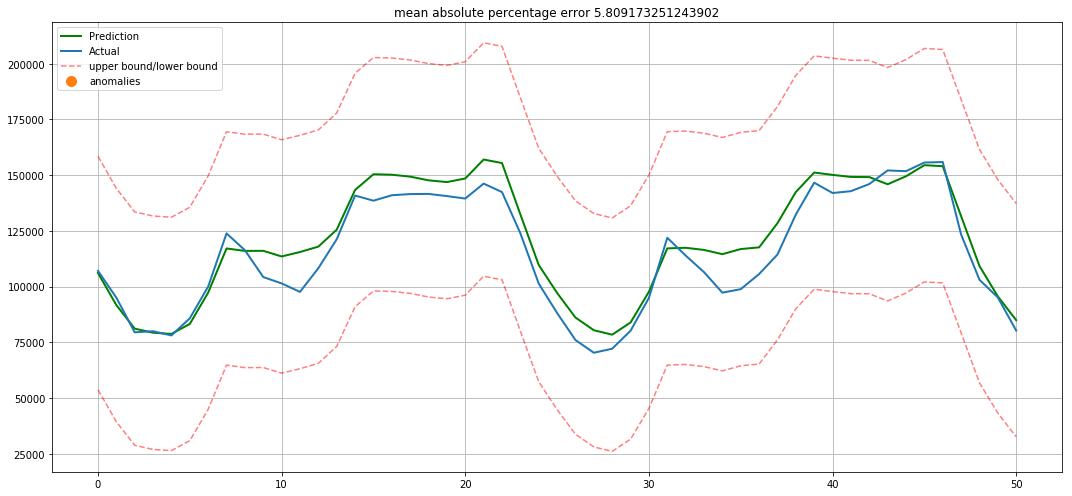

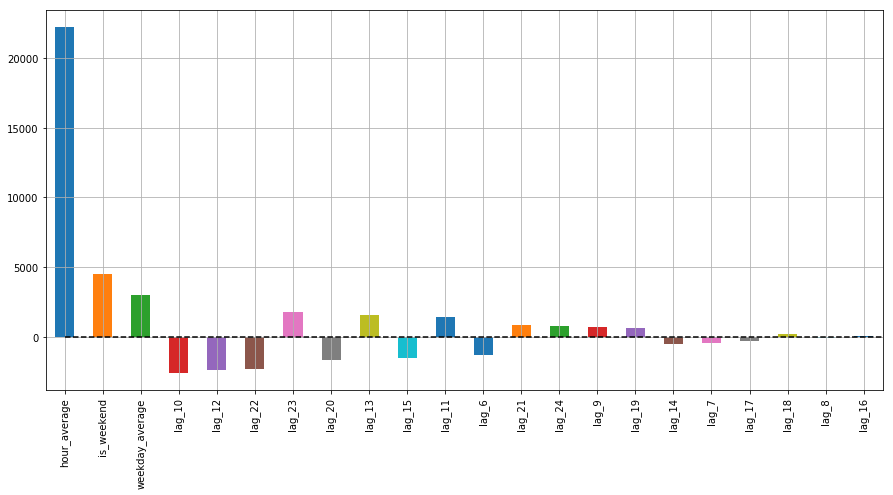

In [87]:
def prepareData(series, lag_start, lag_end, test_size, target_encoding=False):
    """
    series: pd.Dataframe, timeseries data
    
    lag_start: int, initial step back in time to slice target variable
    
    lag_end: int, final step back in time to slice target variable
    
    test_size: float, size of test dataset as percentage
    
    target_encoding: boolean, add target averages to the dataset if true
    
    """
    
    data = pd.DataFrame(series.copy())
    data.columns = ['y']
    
    for i in range(lag_start, lag_end):
        data[f"lag_{i}"] = data.y.shift(i)
    
    data.index = data.index.to_pydatetime()
    data['hour'] = data.index.hour
    data['weekday'] = data.index.weekday
    data['is_weekend'] = data.weekday.isin([5, 6])*1
    
    if target_encoding:
        test_index = int(len(data.dropna())*(1-test_size))
        data['weekday_average'] = list(map(code_mean(data[:test_index], 'weekday', 'y').get, data.weekday))
        data['hour_average'] = list(map(code_mean(data[:test_index], 'hour', 'y').get, data.hour))
        data.drop(["hour", "weekday"], axis=1, inplace=True)
    
    y = data.dropna().y
    X = data.dropna().drop(['y'], axis=1)
    X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=test_size)
    
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = prepareData(ads.Ads, lag_start = 6, lag_end=25, test_size=0.3, target_encoding=True)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

plotModelResults(lr, X_train=X_train_scaled, X_test = X_test_scaled, plot_intervals=True, plot_anomalies=True)
plotCoefficients(lr)


    
    
    
    
    

Hour_average is too large -- consequences of overfitting.

In [88]:
X_train, X_test, y_train, y_test =\
prepareData(ads.Ads, lag_start=6, lag_end=25, test_size=0.3, target_encoding=False)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

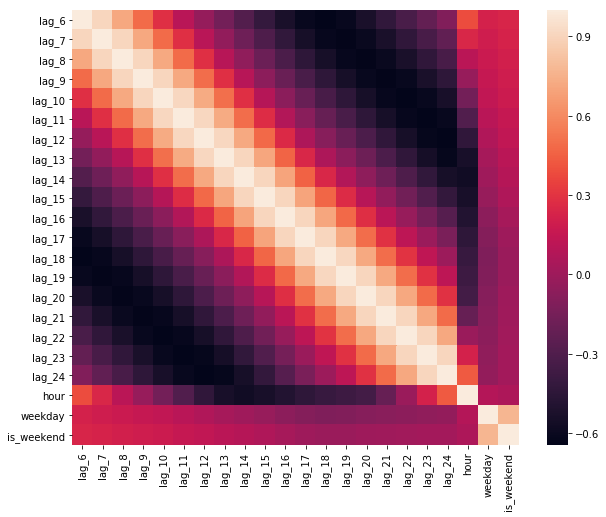

In [89]:
plt.figure(figsize=(10, 8))
sns.heatmap(X_train.corr())

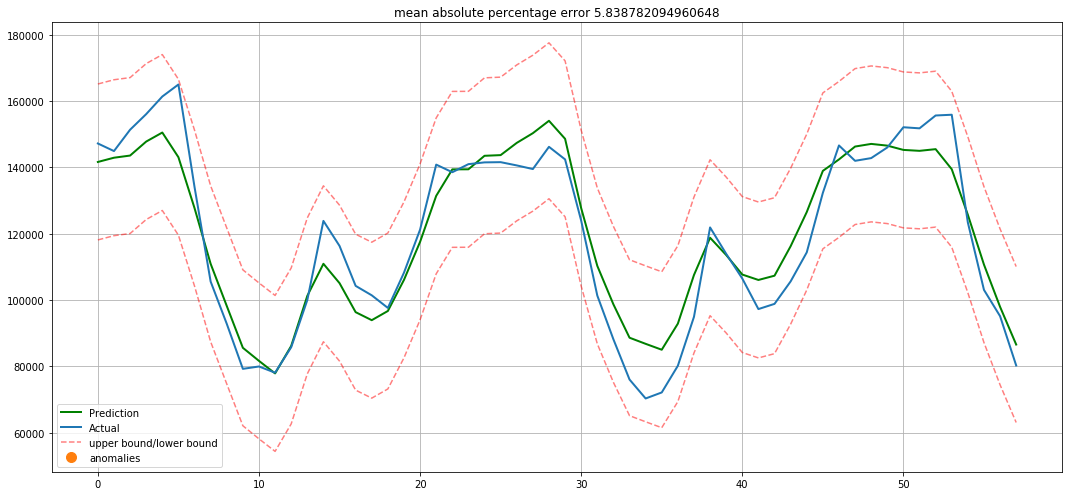

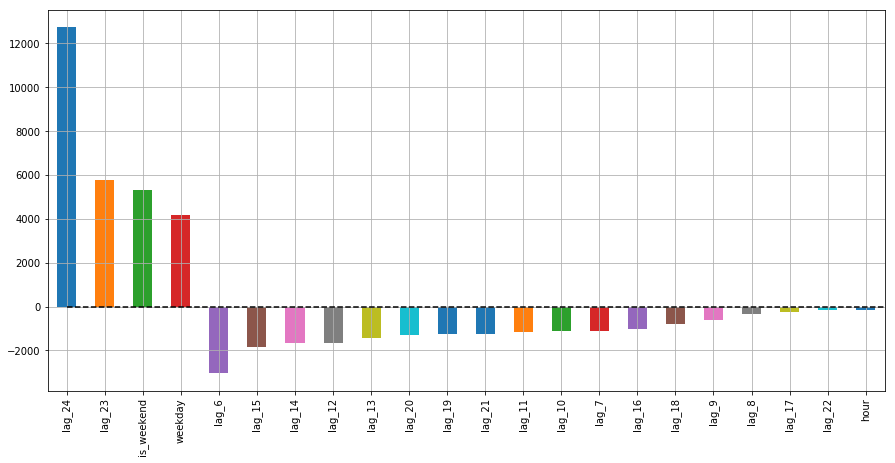

In [90]:
from sklearn.linear_model import LassoCV, RidgeCV

ridge = RidgeCV(cv=tscv)
ridge.fit(X_train_scaled, y_train)

plotModelResults(ridge, X_train= X_train_scaled, X_test = X_test_scaled, plot_intervals=True, plot_anomalies=True)
plotCoefficients(ridge)

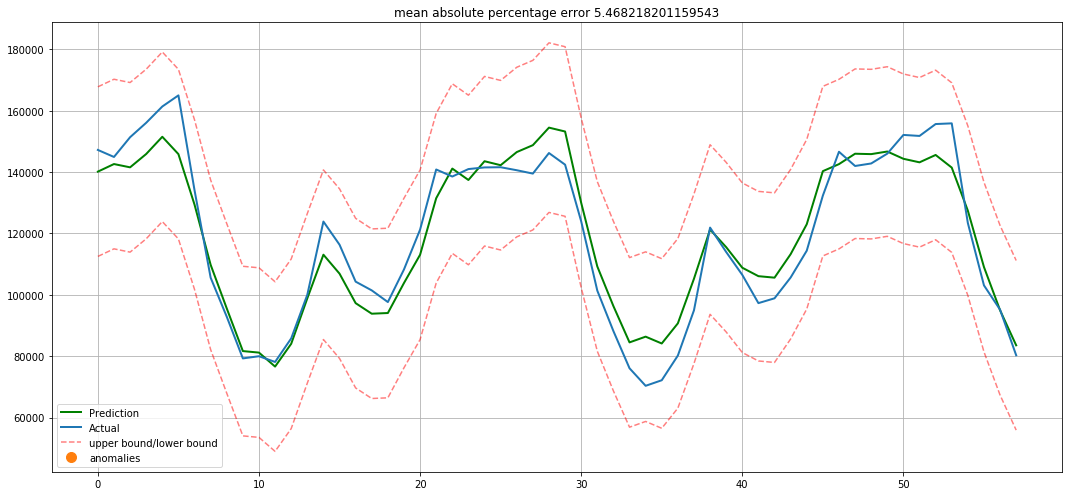

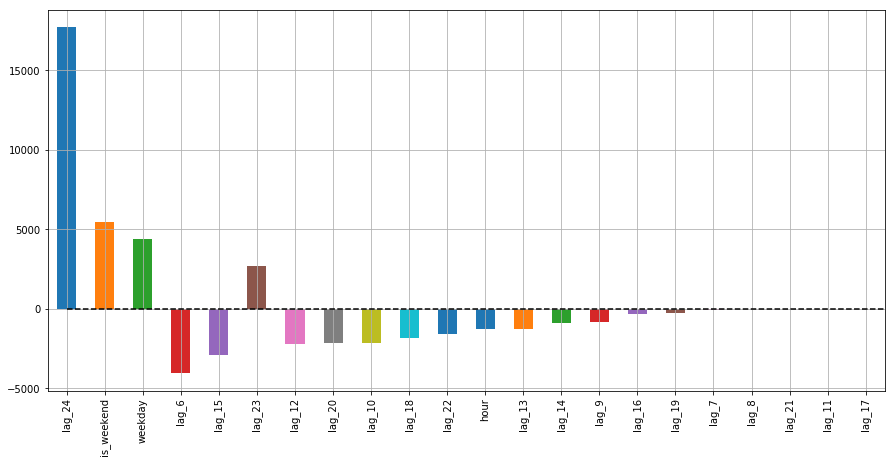

In [91]:
lasso = LassoCV(cv=tscv)
lasso.fit(X_train_scaled, y_train)

plotModelResults(lasso, X_train =X_train_scaled, X_test= X_test_scaled,plot_intervals=True, plot_anomalies=True)
plotCoefficients(lasso)

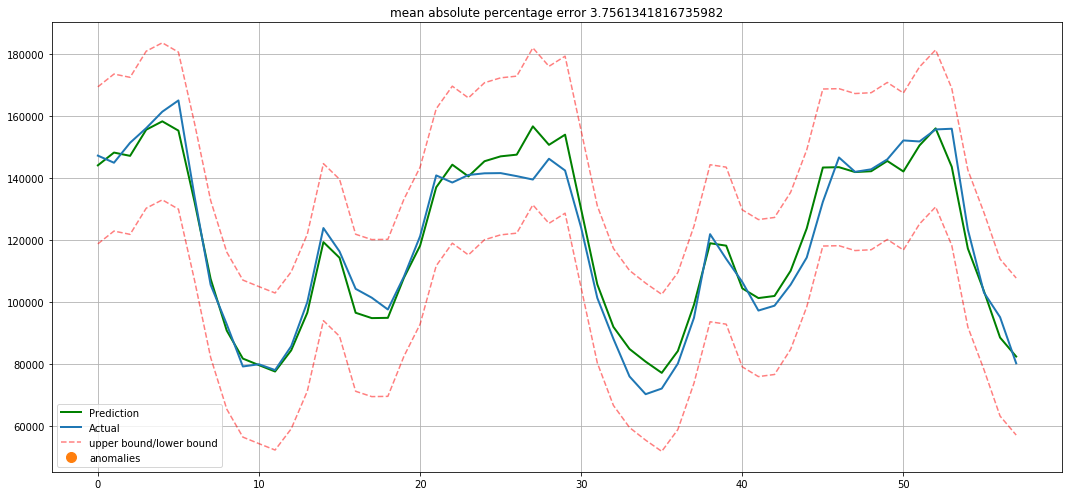

In [93]:
from xgboost import XGBRegressor

xgb = XGBRegressor()
xgb.fit(X_train_scaled, y_train)
plotModelResults(xgb, X_train=X_train_scaled, X_test=X_test_scaled, plot_intervals=True, plot_anomalies=True)
